## <a id="Lib">Import Liberay </a>

In [30]:
import re  # For preprocessing
import multiprocessing
import logging 
import pandas as pd  # For data handling
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from time import time  # To time our operations
from collections import defaultdict  # For word frequency
from gensim.models.phrases import Phrases,Phraser
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
 
sns.set_style("darkgrid")

# Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [3]:
data = pd.read_csv("stackdata.csv")

## <a id="Display"> About Data</a>

In [4]:
display(data.info(),data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            45000 non-null  int64 
 1   Title         45000 non-null  object
 2   Body          45000 non-null  object
 3   Tags          45000 non-null  object
 4   CreationDate  45000 non-null  object
 5   Y             45000 non-null  object
dtypes: int64(1), object(5)
memory usage: 2.1+ MB


None

,Id,Title,Body,Tags,CreationDate,Y
0,34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,2016-01-01 00:21:59,LQ_CLOSE
1,34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2016-01-01 02:03:20,HQ
2,34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,HQ
3,34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,HQ
4,34553755,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,2016-01-01 05:21:48,HQ


## <a id='Pre-Processing'>Pre-Processing</a> 

Note:- We are currently going to use only two columns but we are still going to keep 2 more columns just for later use
<ul>
  <li>1. <code> Id , CreationDate </code> were not usefull at the current point. </li>
  <li>2. And let's transform the <code> 'Y' </code> column into " 0,1,2 " </li>
</ul>

In [5]:
dummy_data = data[['Title','Body','Tags','Y']]
dummy_data['Y'] = dummy_data['Y'].map({'LQ_CLOSE':0, 'LQ_EDIT': 1, 'HQ':2})
dummy_data.head()

/var/folders/b8/bmq4rlpn1d32yd4c88zdz0600000gp/T/ipykernel_82321/2368618481.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dummy_data['Y'] = dummy_data['Y'].map({'LQ_CLOSE':0, 'LQ_EDIT': 1, 'HQ':2})


,Title,Body,Tags,Y
0,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,0
1,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2
2,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2
3,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2
4,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,2


### Again let's combine <code> 'Text' = Title and Body </code> 

In [6]:
dummy_data['text'] = dummy_data['Title'] + ' ' + dummy_data['Body']
dummy_data = dummy_data.drop(['Title', 'Body'], axis=1)
dummy_data.head()


/var/folders/b8/bmq4rlpn1d32yd4c88zdz0600000gp/T/ipykernel_82321/968390365.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dummy_data['text'] = dummy_data['Title'] + ' ' + dummy_data['Body']


,Tags,Y,text
0,<java><repeat>,0,Java: Repeat Task Every Random Seconds <p>I'm ...
1,<java><optional>,2,Why are Java Optionals immutable? <p>I'd like ...
2,<javascript><image><overlay><react-native><opa...,2,Text Overlay Image with Darkened Opacity React...
3,<swift><operators><whitespace><ternary-operato...,2,Why ternary operator in swift is so picky? <p>...
4,<android><material-design><floating-action-but...,2,hide/show fab with scale animation <p>I'm usin...


## <a id='Cleaning'>Cleaning Text</a> 

In [7]:
def cleaning(doc):
    #remove stopwords + Lemmitze them 
    txt = [token.lemma_ for token in doc if not token.is_stop]
    if len(txt)>2:
        return ' '.join(txt)

### Removing characters other than alpha numeric characters 

In [8]:
init_cleaning = (re.sub("[^A-Za-z]+",' ',str(row)).lower() for row in dummy_data['text'])

## Cleaned Data: 
Now that we have cleaned data lets store it in a new dataframe and drop any null/ missing values or duplicates 

In [9]:
df_clean = pd.DataFrame({'clean':init_cleaning})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(45000, 1)

## <a id='Bigrams'>Bigrams</a>
We are using Gensim Phrases package to automatically detect common phrases (bigrams) from a list of sentences.

In [10]:
from gensim.models.phrases import Phrases,Phraser

As Phrases() takes a list of list of words as input:

In [11]:
sent = [row.split() for row in df_clean['clean']]

Creates the relevant phrases from the list of sentences:

In [12]:
phrases = Phrases(sent,min_count=30, progress_per=10000)

INFO - 18:20:50: collecting all words and their counts
INFO - 18:20:50: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 18:20:52: PROGRESS: at sentence #10000, processed 1452721 words and 484722 word types
INFO - 18:20:54: PROGRESS: at sentence #20000, processed 2933448 words and 829515 word types
INFO - 18:20:55: PROGRESS: at sentence #30000, processed 4416610 words and 1131514 word types
INFO - 18:20:57: PROGRESS: at sentence #40000, processed 5846341 words and 1402395 word types
INFO - 18:20:58: collected 1526423 token types (unigram + bigrams) from a corpus of 6540230 words and 45000 sentences
INFO - 18:20:58: merged Phrases<1526423 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>
INFO - 18:20:58: Phrases lifecycle event {'msg': 'built Phrases<1526423 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000> in 7.84s', 'datetime': '2022-10-04T18:20:58.564483', 'gensim': '4.1.2', 'python': '3.9.12 (main, Apr  5 2022, 01:53:17) \n[Clang 12.0.0 ]',

The goal of Phraser() is to cut down memory consumption of Phrases(), by discarding model state not strictly needed for the bigram detection task:

In [13]:
bigram = Phraser(phrases)

INFO - 18:20:58: exporting phrases from Phrases<1526423 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>
INFO - 18:21:01: FrozenPhrases lifecycle event {'msg': 'exported FrozenPhrases<3257 phrases, min_count=30, threshold=10.0> from Phrases<1526423 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000> in 2.96s', 'datetime': '2022-10-04T18:21:01.532827', 'gensim': '4.1.2', 'python': '3.9.12 (main, Apr  5 2022, 01:53:17) \n[Clang 12.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


Transform the corpus based on the bigrams detected:

In [14]:
sentences = bigram[sent]

## <a id='Frequent'>Most Frequent Words:</a>
Mainly a sanity check of the effectiveness of the lemmatization, removal of stopwords, and addition of bigrams.

In [15]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

140897

## <a id='Model'>Training the model</a>
## Gensim Word2Vec Implementation:
We use Gensim implementation of word2vec:

## Model in 3 Steps: 

1. `Word2Vec()`: 
>In this first step, I set up the parameters of the model one-by-one. <br>I do not supply the parameter `sentences`, and therefore leave the model uninitialized, purposefully.
2. `.build_vocab()`: 
>Here it builds the vocabulary from a sequence of sentences and thus initialized the model. <br>With the loggings, I can follow the progress and even more important, the effect of `min_count` and `sample` on the word corpus. 
3. `.train()`:
>Finally, trains the model.<br>
The loggings here are mainly useful for monitoring, making sure that no threads are executed instantaneously.

In [19]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

## <a id='parms'> The parameters </a> :

* `min_count` <font color='purple'>=</font> <font color='green'>int</font> - Ignores all words with total absolute frequency lower than this - (2, 100)


* `window` <font color='purple'>=</font> <font color='green'>int</font> - The maximum distance between the current and predicted word within a sentence. E.g. `window` words on the left and `window` words on the left of our target - (2, 10)


* `vector_size` <font color='purple'>=</font> <font color='green'>int</font> - Dimensionality of the feature vectors. - (50, 300)


* `negative` <font color='purple'>=</font> <font color='green'>int</font> - If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drown. If set to 0, no negative sampling is used. - (5, 20)


* `workers` <font color='purple'>=</font> <font color='green'>int</font> - Use these many worker threads to train the model (=faster training with multicore machines)

In [22]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     vector_size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

INFO - 18:22:53: Word2Vec lifecycle event {'params': 'Word2Vec(vocab=0, vector_size=300, alpha=0.03)', 'datetime': '2022-10-04T18:22:53.984084', 'gensim': '4.1.2', 'python': '3.9.12 (main, Apr  5 2022, 01:53:17) \n[Clang 12.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


## <a id='Vocab'> Building the Vocabulary Table:</a>
Word2Vec requires us to build the vocabulary table (simply digesting all the words and filtering out the unique words, and doing some basic counts on them):

In [23]:
t = time()

w2v_model.build_vocab(sentences, update=False)


print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 18:22:58: collecting all words and their counts
INFO - 18:22:58: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 18:22:59: PROGRESS: at sentence #10000, processed 1339511 words, keeping 50091 word types
INFO - 18:23:00: PROGRESS: at sentence #20000, processed 2704469 words, keeping 79938 word types
INFO - 18:23:02: PROGRESS: at sentence #30000, processed 4062766 words, keeping 105741 word types
INFO - 18:23:03: PROGRESS: at sentence #40000, processed 5380844 words, keeping 129715 word types
INFO - 18:23:03: collected 140897 word types from a corpus of 6022014 raw words and 45000 sentences
INFO - 18:23:03: Creating a fresh vocabulary
INFO - 18:23:03: Word2Vec lifecycle event {'msg': 'effective_min_count=20 retains 13378 unique words (9.49487923802494%% of original 140897, drops 127519)', 'datetime': '2022-10-04T18:23:03.931222', 'gensim': '4.1.2', 'python': '3.9.12 (main, Apr  5 2022, 01:53:17) \n[Clang 12.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bi

Time to build vocab: 0.1 mins


## <a id='Training'> Training of the model:</a>
_Parameters of the training:_
* `total_examples` <font color='purple'>=</font> <font color='green'>int</font> - Count of sentences;
* `epochs` <font color='purple'>=</font> <font color='green'>int</font> - Number of iterations (epochs) over the corpus - [10, 20, 30]

In [24]:
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 18:23:06: Word2Vec lifecycle event {'msg': 'training model with 11 workers on 13378 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2 shrink_windows=True', 'datetime': '2022-10-04T18:23:06.945783', 'gensim': '4.1.2', 'python': '3.9.12 (main, Apr  5 2022, 01:53:17) \n[Clang 12.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'train'}
INFO - 18:23:07: EPOCH 1 - PROGRESS: at 9.65% examples, 241967 words/s, in_qsize 22, out_qsize 0
INFO - 18:23:09: EPOCH 1 - PROGRESS: at 23.73% examples, 288505 words/s, in_qsize 21, out_qsize 0
INFO - 18:23:10: EPOCH 1 - PROGRESS: at 35.87% examples, 296665 words/s, in_qsize 13, out_qsize 8
INFO - 18:23:11: EPOCH 1 - PROGRESS: at 48.95% examples, 305373 words/s, in_qsize 20, out_qsize 2
INFO - 18:23:12: EPOCH 1 - PROGRESS: at 63.95% examples, 318527 words/s, in_qsize 21, out_qsize 0
INFO - 18:23:13: EPOCH 1 - PROGRESS: at 78.76% examples, 325869 words/s, in_qsize 21, out_qsize 0
INFO - 18:23:14: EPOCH 1 - PR

INFO - 18:23:43: worker thread finished; awaiting finish of 0 more threads
INFO - 18:23:43: EPOCH - 5 : training on 6022014 raw words (2519156 effective words) took 7.9s, 320709 effective words/s
INFO - 18:23:44: EPOCH 6 - PROGRESS: at 8.24% examples, 206803 words/s, in_qsize 19, out_qsize 0
INFO - 18:23:45: EPOCH 6 - PROGRESS: at 21.24% examples, 262127 words/s, in_qsize 14, out_qsize 2
INFO - 18:23:46: EPOCH 6 - PROGRESS: at 33.41% examples, 275674 words/s, in_qsize 13, out_qsize 8
INFO - 18:23:47: EPOCH 6 - PROGRESS: at 46.89% examples, 294045 words/s, in_qsize 21, out_qsize 0
INFO - 18:23:49: EPOCH 6 - PROGRESS: at 59.79% examples, 296302 words/s, in_qsize 13, out_qsize 9
INFO - 18:23:50: EPOCH 6 - PROGRESS: at 73.69% examples, 301813 words/s, in_qsize 22, out_qsize 0
INFO - 18:23:51: EPOCH 6 - PROGRESS: at 86.65% examples, 302112 words/s, in_qsize 21, out_qsize 0
INFO - 18:23:51: worker thread finished; awaiting finish of 10 more threads
INFO - 18:23:51: worker thread finished; aw

INFO - 18:24:22: EPOCH - 10 : training on 6022014 raw words (2520371 effective words) took 7.6s, 329832 effective words/s
INFO - 18:24:23: EPOCH 11 - PROGRESS: at 9.14% examples, 233003 words/s, in_qsize 21, out_qsize 0
INFO - 18:24:24: EPOCH 11 - PROGRESS: at 23.89% examples, 284104 words/s, in_qsize 21, out_qsize 0
INFO - 18:24:25: EPOCH 11 - PROGRESS: at 38.62% examples, 313411 words/s, in_qsize 20, out_qsize 1
INFO - 18:24:26: EPOCH 11 - PROGRESS: at 53.12% examples, 322406 words/s, in_qsize 21, out_qsize 0
INFO - 18:24:27: EPOCH 11 - PROGRESS: at 67.11% examples, 330296 words/s, in_qsize 14, out_qsize 8
INFO - 18:24:28: EPOCH 11 - PROGRESS: at 80.30% examples, 329387 words/s, in_qsize 21, out_qsize 0
INFO - 18:24:29: EPOCH 11 - PROGRESS: at 96.22% examples, 337577 words/s, in_qsize 21, out_qsize 0
INFO - 18:24:29: worker thread finished; awaiting finish of 10 more threads
INFO - 18:24:29: worker thread finished; awaiting finish of 9 more threads
INFO - 18:24:29: worker thread fini

INFO - 18:25:01: EPOCH 16 - PROGRESS: at 9.97% examples, 243775 words/s, in_qsize 21, out_qsize 0
INFO - 18:25:02: EPOCH 16 - PROGRESS: at 22.57% examples, 274224 words/s, in_qsize 21, out_qsize 1
INFO - 18:25:03: EPOCH 16 - PROGRESS: at 35.56% examples, 285692 words/s, in_qsize 21, out_qsize 0
INFO - 18:25:04: EPOCH 16 - PROGRESS: at 48.80% examples, 287412 words/s, in_qsize 21, out_qsize 0
INFO - 18:25:05: EPOCH 16 - PROGRESS: at 61.61% examples, 289583 words/s, in_qsize 21, out_qsize 0
INFO - 18:25:06: EPOCH 16 - PROGRESS: at 73.07% examples, 289272 words/s, in_qsize 19, out_qsize 2
INFO - 18:25:07: EPOCH 16 - PROGRESS: at 86.31% examples, 292176 words/s, in_qsize 21, out_qsize 0
INFO - 18:25:08: worker thread finished; awaiting finish of 10 more threads
INFO - 18:25:08: worker thread finished; awaiting finish of 9 more threads
INFO - 18:25:08: worker thread finished; awaiting finish of 8 more threads
INFO - 18:25:08: worker thread finished; awaiting finish of 7 more threads
INFO - 

INFO - 18:25:40: EPOCH 21 - PROGRESS: at 8.39% examples, 213504 words/s, in_qsize 13, out_qsize 4
INFO - 18:25:41: EPOCH 21 - PROGRESS: at 20.04% examples, 249416 words/s, in_qsize 20, out_qsize 1
INFO - 18:25:42: EPOCH 21 - PROGRESS: at 31.92% examples, 263860 words/s, in_qsize 21, out_qsize 0
INFO - 18:25:43: EPOCH 21 - PROGRESS: at 43.49% examples, 272102 words/s, in_qsize 14, out_qsize 6
INFO - 18:25:44: EPOCH 21 - PROGRESS: at 55.33% examples, 277729 words/s, in_qsize 19, out_qsize 0
INFO - 18:25:45: EPOCH 21 - PROGRESS: at 66.28% examples, 278110 words/s, in_qsize 21, out_qsize 0
INFO - 18:25:46: EPOCH 21 - PROGRESS: at 78.35% examples, 282067 words/s, in_qsize 21, out_qsize 0
INFO - 18:25:47: EPOCH 21 - PROGRESS: at 90.54% examples, 283044 words/s, in_qsize 21, out_qsize 0
INFO - 18:25:48: worker thread finished; awaiting finish of 10 more threads
INFO - 18:25:48: worker thread finished; awaiting finish of 9 more threads
INFO - 18:25:48: worker thread finished; awaiting finish o

INFO - 18:26:23: worker thread finished; awaiting finish of 2 more threads
INFO - 18:26:23: worker thread finished; awaiting finish of 1 more threads
INFO - 18:26:23: worker thread finished; awaiting finish of 0 more threads
INFO - 18:26:23: EPOCH - 25 : training on 6022014 raw words (2519172 effective words) took 8.6s, 291703 effective words/s
INFO - 18:26:24: EPOCH 26 - PROGRESS: at 6.90% examples, 177992 words/s, in_qsize 19, out_qsize 2
INFO - 18:26:25: EPOCH 26 - PROGRESS: at 18.34% examples, 228398 words/s, in_qsize 20, out_qsize 0
INFO - 18:26:26: EPOCH 26 - PROGRESS: at 31.04% examples, 256356 words/s, in_qsize 15, out_qsize 0
INFO - 18:26:27: EPOCH 26 - PROGRESS: at 41.74% examples, 261191 words/s, in_qsize 21, out_qsize 0
INFO - 18:26:28: EPOCH 26 - PROGRESS: at 55.17% examples, 273536 words/s, in_qsize 21, out_qsize 0
INFO - 18:26:29: EPOCH 26 - PROGRESS: at 67.78% examples, 282043 words/s, in_qsize 14, out_qsize 1
INFO - 18:26:30: EPOCH 26 - PROGRESS: at 80.14% examples, 28

INFO - 18:27:06: worker thread finished; awaiting finish of 7 more threads
INFO - 18:27:06: worker thread finished; awaiting finish of 6 more threads
INFO - 18:27:06: worker thread finished; awaiting finish of 5 more threads
INFO - 18:27:06: worker thread finished; awaiting finish of 4 more threads
INFO - 18:27:06: worker thread finished; awaiting finish of 3 more threads
INFO - 18:27:06: worker thread finished; awaiting finish of 2 more threads
INFO - 18:27:06: worker thread finished; awaiting finish of 1 more threads
INFO - 18:27:06: worker thread finished; awaiting finish of 0 more threads
INFO - 18:27:06: EPOCH - 30 : training on 6022014 raw words (2520483 effective words) took 8.2s, 308339 effective words/s
INFO - 18:27:06: Word2Vec lifecycle event {'msg': 'training on 180660420 raw words (75611216 effective words) took 239.1s, 316234 effective words/s', 'datetime': '2022-10-04T18:27:06.043054', 'gensim': '4.1.2', 'python': '3.9.12 (main, Apr  5 2022, 01:53:17) \n[Clang 12.0.0 ]',

Time to train the model: 4.13 mins


# <a id='Exploring'>Exploring the model</a>
## <a id='similar'>Most similar to:</a>

Here, we will ask our model to find the word most similar to some of the words in the corpus

In [25]:
w2v_model.wv.most_similar(positive=["java"])

[('kotlin', 0.4408639371395111),
 ('scala', 0.393154114484787),
 ('jdk', 0.37687715888023376),
 ('python', 0.37434151768684387),
 ('java_util', 0.3635866641998291),
 ('stdlib', 0.3618549704551697),
 ('core_jar', 0.35858240723609924),
 ('jaxb', 0.35346150398254395),
 ('tomcat_embed', 0.35154345631599426),
 ('eclipse', 0.35048243403434753)]

### <a id='t-SNE'>t-SNE visualizations:</a>
t-SNE is a non-linear dimensionality reduction algorithm that attempts to represent high-dimensional data and the underlying relationships between vectors in a lower-dimensional space.<br>

To make the visualizations more relevant, we will look at the relationships between a query word (in <font color='red'>**red**</font>), its most similar words in the model (in <font color="blue">**blue**</font>), and other words from the vocabulary (in <font color='green'>**green**</font>).

In [26]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality  with PCA
    reduc = PCA(n_components=20).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    

## <a id='PLOTS'>Let's check the 20 similar words to Java and plot it. </a>

/Users/usman/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/usman/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


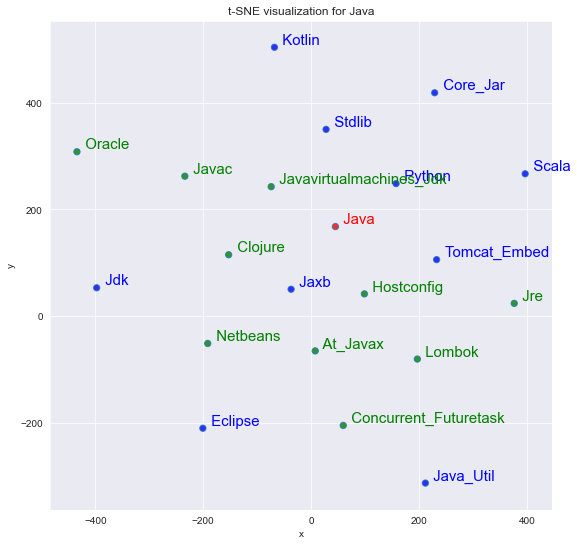

In [31]:
tsnescatterplot(w2v_model, 'java',[t[0] for t in w2v_model.wv.most_similar(positive=["java"], topn=20)][10:])

## Let's see the difference as to how top 30 similar words make a difference

/Users/usman/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/usman/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


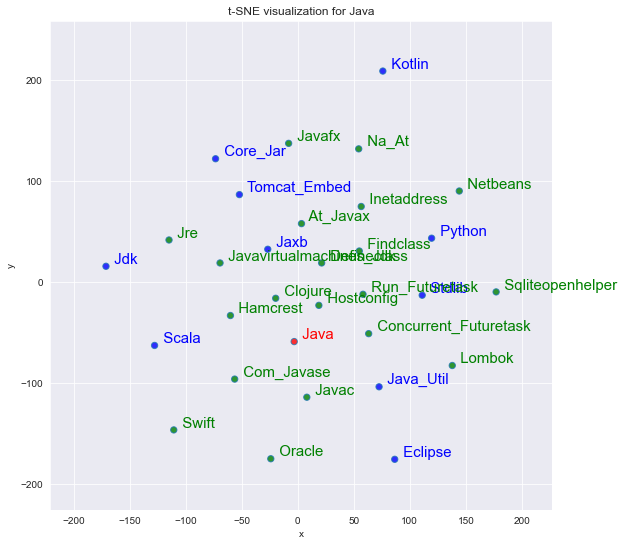

In [32]:
tsnescatterplot(w2v_model, 'java',[t[0] for t in w2v_model.wv.most_similar(positive=["java"], topn=30)][10:])

Again I can find words that are related to Java Which is pretty good.  

## Let's see if it works for other words

/Users/usman/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/usman/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


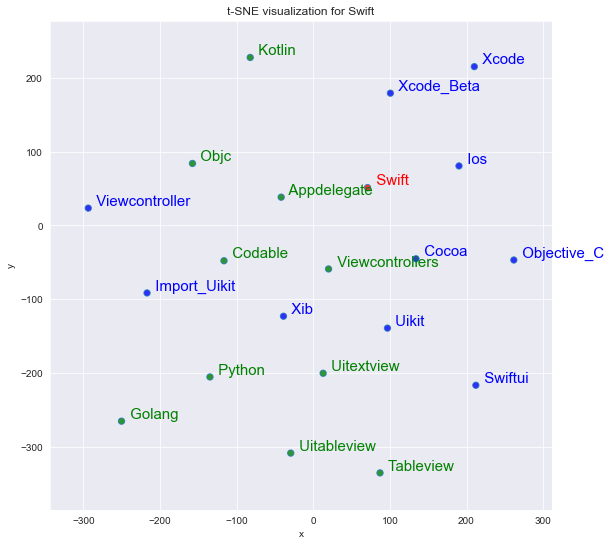

In [33]:
tsnescatterplot(w2v_model, 'swift',[t[0] for t in w2v_model.wv.most_similar(positive=["swift"], topn=20)][10:])

It is again giving great results.

## Let's see if it works for something random

/Users/usman/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/usman/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


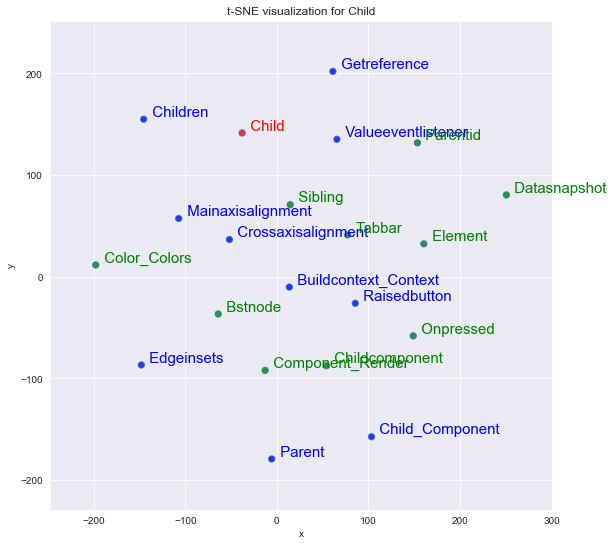

In [34]:
tsnescatterplot(w2v_model, 'child',[t[0] for t in w2v_model.wv.most_similar(positive=["child"], topn=20)][10:])

The results are great it actually found similar words to Child and it was able to comprehend it with  "Classes and Child" which is great. 